# Automated Machine Learning

Group 18 Members:

- Clara Pichler, 11917694
- Hannah Knapp, 11901857 
- Sibel Toprakkiran, 09426341

### Overview

1. simulated annealing algorithm
- 

2. Comparison with two state of the art AutoML systems
- auto-sklearn 
- TPOT

5. Evaluation
- Dataset 1
- Dataset 2
- Dataset 3
- Dataset 4

## Data sets

- Iris Dataset
- 
-
-

In [3]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import time

## Input

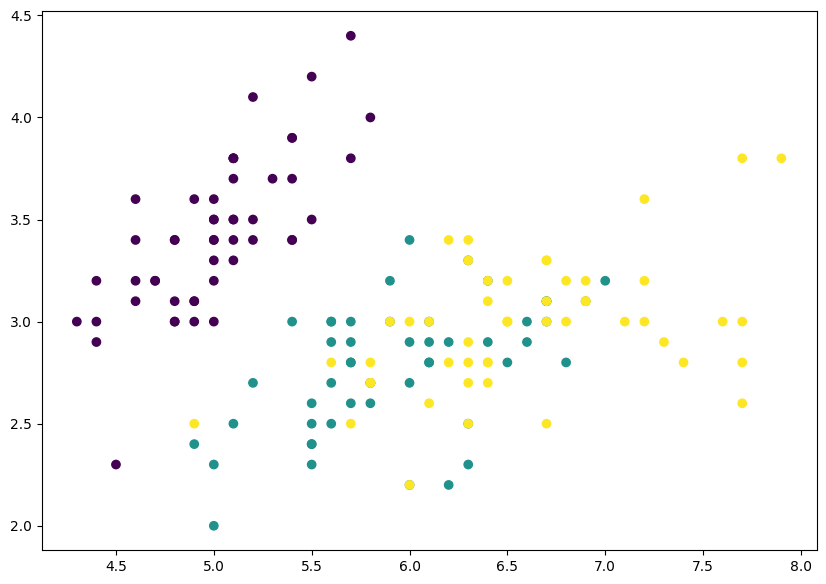

In [4]:
iris = datasets.load_iris()
iris_data = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])
iris_data['target'] = iris_data['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

plt.figure(figsize=(10, 7))
x = iris_data["sepal length (cm)"]
y = iris_data["sepal width (cm)"]
plt.scatter(x, y, c=iris.target)

## test-validation-train split

In [5]:
X = iris_data.drop(['target'], axis=1)
y = iris_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Models
- MLP
- RF
- KNN 
- SVM
- AdaBoost

## AutoML algorithm

In [6]:
class AutoML_18:
    def __init__(self, initial_temp=100, cooling_rate=0.99, max_iterations=100, min_training_time=2):
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations
        self.min_training_time = max(min_training_time, 3600)
        self.algorithms = {
            "MLP": {
                "class": MLPClassifier,
                "parameters": ["max_iter", "activation", "solver", "alpha"],
                "values": [[1000, 2000, 3000], ['relu', 'tanh', 'logistic'], ['adam', 'sgd'], [0.0001, 0.001, 0.01]]
            },
            "RF": {
                "class": RandomForestClassifier,
                "parameters": ["n_estimators", "max_depth", "min_samples_split", "max_features", "criterion"],
                "values": [[10, 25, 50, 100, 150], [5, 10, 15], [2, 3, 3, 4], ['sqrt', 'log2', None], ['gini', 'log_loss', 'entropy']]
            },
            "KNN": {
                "class": KNeighborsClassifier,
                "parameters": ["n_neighbors", "weights", "algorithm", "leaf_size"],
                "values": [[3, 5, 7, 9, 11], ['uniform', 'distance'], ['auto', 'ball_tree', 'kd_tree', 'brute'], [10, 20, 30, 40, 50]]
            },
            "SVM": {
                "class": SVC,
                "parameters": ["C", "kernel", "gamma"],
                "values": [[1, 10, 100, 1000], ['linear', 'poly', 'rbf', 'sigmoid'], ['scale', 'auto']]
            },
            "AdaBoost": {
                "class": AdaBoostClassifier,
                "parameters": ["n_estimators", "learning_rate"],
                "values": [[10, 25, 50, 100, 150], [0.1, 0.5, 1, 1.5, 2]]
            },
        }
        self.best_solution = None
        self.best_score = 0
        self.model = None
        
    def eval(self, model, X, y):
        scores = cross_val_score(model, X, y, cv=5)
        print('scores=' + str(np.mean(scores)))
        return np.mean(scores)

    def generate_neighborhood(self, current_solution):
        new_solution = current_solution.copy()
        algorithm_name = np.random.choice(list(self.algorithms.keys()))
        new_solution[0] = algorithm_name

        algorithm_info = self.algorithms[algorithm_name]
        num_params = len(algorithm_info['parameters'])
        
        new_solution = [new_solution[0]]  # Reset to only the algorithm name
        
        for i in range(num_params):
            values = algorithm_info['values'][i]
            
            if isinstance(values, list):
                if isinstance(values[0], tuple):
                    new_solution.append(np.random.choice(values))
                elif isinstance(values[0], str):
                    new_solution.append(np.random.choice(values))
                else:
                    new_solution.append(np.random.choice(values))
            else:
                new_solution.append(np.random.uniform(*values))

        print(f"Neighborhood algorithm: {algorithm_name}, parameters: {new_solution[1:]}")
        return new_solution

    def create_model(self, solution):
        algorithm_name = solution[0]
        hyperparameters = solution[1:]
        algorithm_class = self.algorithms[algorithm_name]['class']
        
        if algorithm_name == 'MLP':
            return algorithm_class(
                max_iter=hyperparameters[0],
                activation=hyperparameters[1],
                solver=hyperparameters[2],
                alpha=hyperparameters[3]
            )
        elif algorithm_name == 'RF':
            return algorithm_class(
                n_estimators=hyperparameters[0],
                max_depth=hyperparameters[1],
                min_samples_split=hyperparameters[2],
                max_features=hyperparameters[3],
                criterion=hyperparameters[4]
            )
        elif algorithm_name == 'KNN':
            return algorithm_class(
                n_neighbors=hyperparameters[0],
                weights=hyperparameters[1],
                algorithm=hyperparameters[2],
                leaf_size=hyperparameters[3]
            )
        elif algorithm_name == 'SVM':
            return algorithm_class(
                C=hyperparameters[0],
                kernel=hyperparameters[1],
                gamma=hyperparameters[2]
            )
        elif algorithm_name == 'AdaBoost':
            return algorithm_class(
                n_estimators=hyperparameters[0],
                learning_rate=hyperparameters[1],
            )

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.simulated_annealing()

    def predict(self, X):
        if self.model is None:
            raise ValueError("The model has not been fit yet. Please call the fit method first.")
        return self.model.predict(X)

    def simulated_annealing(self):
        start_time = time.time()
        print(f"Start time: {start_time}") 
        
        current_model = [np.random.choice(list(self.algorithms.keys()))]
        current_hyperparameters = []
        
        for i, param in enumerate(self.algorithms[current_model[0]]['parameters']):
            values = self.algorithms[current_model[0]]['values'][i]
            
            if isinstance(values[0], tuple):
                current_hyperparameters.append(np.random.choice(values[0]))
            elif isinstance(values, list):
                current_hyperparameters.append(np.random.choice(values))
            else:
                current_hyperparameters.append(np.random.uniform(*values))
        
        current_solution = current_model + current_hyperparameters
        
        print(f"Initial model: {current_model[0]}")
        print(f"Initial parameters: {current_hyperparameters}")
   
        current_score = self.eval(self.create_model(current_solution), self.X, self.y)
        best_solution = current_solution
        best_score = current_score
        
        temperature = self.initial_temp
        
        while time.time() - start_time < self.min_training_time:
            for _ in range(100):
                new_solution = self.generate_neighborhood(current_solution)
                new_score = self.eval(self.create_model(new_solution), self.X, self.y)
        
                if new_score > current_score:
                    current_solution = new_solution
                    current_score = new_score
                    if new_score > best_score:
                        best_solution = new_solution
                        best_score = new_score
                else:
                    acceptance_probability = np.exp((new_score - current_score) / temperature)
                    if np.random.rand() < acceptance_probability:
                        current_solution = new_solution
                        current_score = new_score
        
            temperature *= self.cooling_rate
        
        self.best_solution = best_solution
        self.best_score = best_score
        self.model = self.create_model(best_solution)


        
#automl = AutoML_18(min_training_time=3600)  # Set minimum training time to 1 hour
#automl.fit(X, y)
#predictions = automl.predict(X)   

In [2]:
automl = AutoML_18(min_training_time=2)
automl.fit(X_train, y_train)
automl.eval(automl.model, X_val, y_val)
predictions = automl.predict(X_test)

NameError: name 'MLPClassifier' is not defined